In [1]:
#!/usr/bin/env python
# coding: utf-8

# Author : Jay Patel, Dalhousie University
# This code is modified for testing on Subnero Surface Modem.
# Final testing with spreading factor 1024

import codecs
import pylab as plt
import numpy as np

from numpy import fft

Here **s0, s1 and s2** is the msgs from **node1, node 2 and node 3** respectively.

**MSG Format:** (Target:) lat, longh, depth, heading/(bearing), range 
- i.e. : T(Target), lat=6488N, long=63.5752W, depth=35.5, heading = 271.4, range=45.5 (for s0) 

In [2]:
# messages that needs to be converted 
s0 = 'T44.6488N,63.5752W,35.5,271.4,45.5'.encode('utf-8')
s1 = 'T44.6488N,63.5752W,45.5,271.4,45.5'.encode('utf-8')
s2 = 'T44.6488N,63.5752W,55.5,271.4,45.5'.encode('utf-8')

In [4]:
def cconv(x, y):
    """Calculate the circular convolution of 1-D input numpy arrays using DFT
    From the Signal Processing Library: http://mubeta06.github.io/python/sp/filter.html
    """
    return fft.ifft(fft.fft(x)*fft.fft(y))

def ccorr(x, y):
    """Calculate the circular correlation of 1-D input numpy arrays using DFT
    From the Signal Processing Library: http://mubeta06.github.io/python/sp/filter.html
    """
    return fft.ifft(fft.fft(x)*fft.fft(y).conj())

def despread(composite, code, codelength):
    l = len(composite)//codelength
    despread = composite*(code*-2.0+1)
    recovered = []
    for i in range(l):
        recovered = np.append(recovered, 1.0*sum(despread[i*codelength:i*codelength+codelength])//codelength)
    recovered = np.repeat(recovered, codelength)
    return recovered


def bitfield(n):
    """Convert integer into bitfield (as list)
    From StackOverflow: http://stackoverflow.com/a/10322018/
    """
    return [int(digit) for digit in bin(n)[2:]] 


def shift(register, feedback, output):
    """GPS Shift Register
    From https://natronics.github.io/blag/2014/gps-prn/
    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:

    """

    # calculate output
    out = [register[i - 1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]

    # modulo 2 add feedback
    fb = sum([register[i - 1] for i in feedback]) % 2

    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i + 1] = register[i]

    # put feedback in position 1
    register[0] = fb

    return out

SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

def PRN(sv):
    """Build the CA code (PRN) for a given satellite ID
    https://github.com/natronics/gps/blob/master/gps/prn.py
    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite

    """

    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here

    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3 ,10], [10])
        g2 = shift(G2, [2 ,3 ,6 ,8 ,9 ,10], SV[sv]) # <- sat chosen here from table

        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

def de_repeater(seq, size):
    chunks = []
    index = 0
    while index < len(seq):
    #print(list(seq[index:index+size]))
    #print(len(list(seq[index:index+size])))
        chunks.append(list(seq[index:index+size]))
        index+=size

    bits = []
    for List in chunks:
        #print(max(set(List), key = List.count)) 
        bits.append(max(set(List), key = List.count))

    return bits

# Two Gold codes. See 
# Gold, R. "Optimal binary sequences for spread spectrum multiplexing (Corresp.)"
# IEEE Transactions on Information Theory. (October 1967)
# g0 = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
#        1, 1, 0, 1, 0, 0, 0, 1, 0], dtype=int)
# g30 = np.array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
#        0, 0, 0, 1, 1, 0, 0, 0, 1])

g0 = np.array(PRN(1))
g5 = np.array(PRN(5))
g30 = np.array(PRN(10))

codelength = len(g0) # 2^8 = 255
# print(codelength)

# Primary user data
p = s0.hex()
p = int(p, 16)
p = np.array(bitfield(p))
p_len = len(p)
p = np.repeat(p, codelength)
p_code = []
for i in range(p_len):
    p_code = np.append(p_code, g30)

# First secondary user and his code
q = s1.hex()
q = int(q, 16)
q = np.array(bitfield(q))
q_len = len(q)
q = np.repeat(q, codelength)
q_code = []
for i in range(q_len):
    q_code = np.append(q_code, g5)

q_spread = np.logical_xor(q_code, q).astype(int)

# Second secondary user and her code
r = s2.hex()
r = int(r, 16)
r = np.array(bitfield(r))
r_len = len(r)
r = np.repeat(r, codelength)
r_code = []
for i in range(r_len):
    r_code = np.append(r_code, g0)

r_spread = np.logical_xor(r_code, r).astype(int)

# Composite sigal from all three users
composite = (p*2-1) + (r_spread*2-1) + (q_spread*2-1)

#TO double check the values of the composite signal 
# np.set_printoptions(threshold=np.inf)
# composite

# Don't like the way it prints
# for i in composite:
#      print(i)

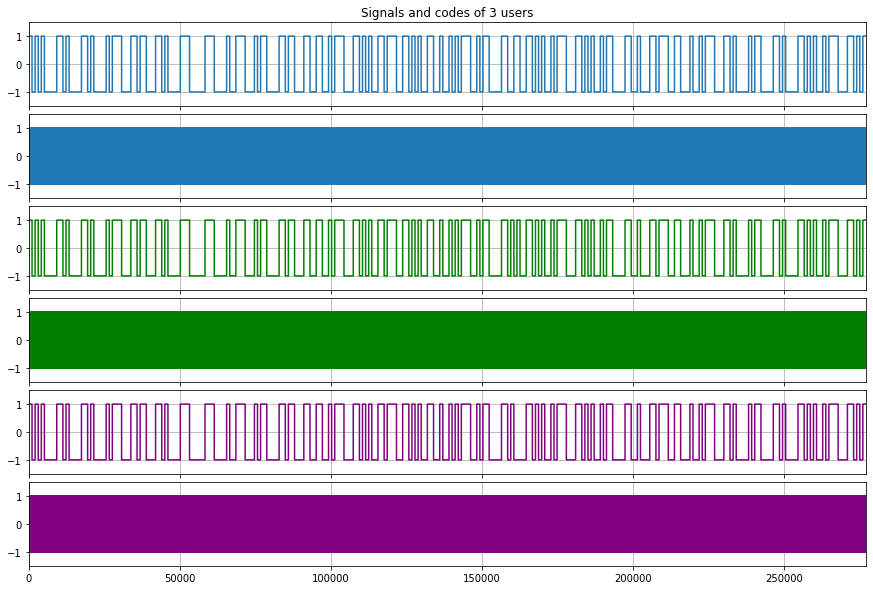

In [5]:
f, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(6, sharex=True, sharey=True, figsize=(15,10))
ax0.set_title('Signals and codes of 3 users')
ax0.step(range(len(p)),p*2-1)
ax0.axis((0,len(r),-1.5,1.5));ax0.grid()
ax1.step(range(len(p_code)),p_code*2-1);ax1.grid()
ax2.step(range(len(r)),r*2-1, color="green");ax2.grid()
ax3.step(range(len(r_code)),r_code*2-1, color="green");ax3.grid()
ax4.step(range(len(q)),q*2-1, color="purple");ax4.grid()
ax5.step(range(len(q_code)),q_code*2-1, color="purple");ax5.grid()
f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

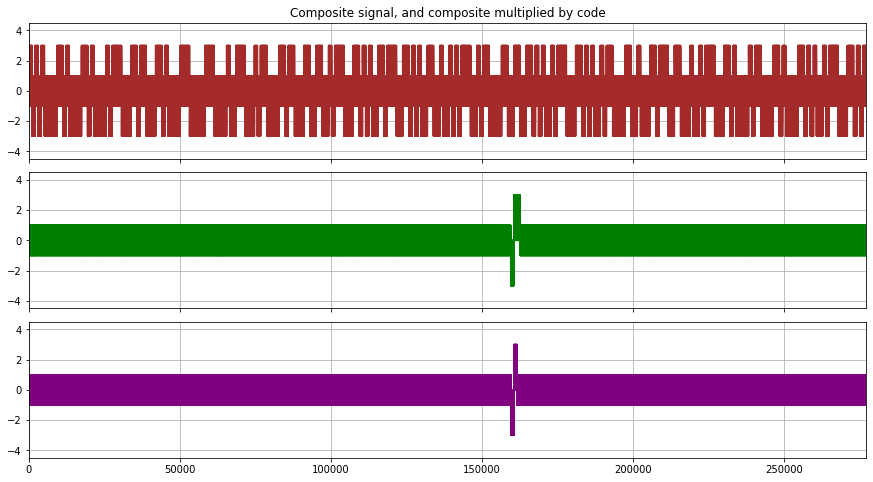

In [6]:
f, (ax0, ax1, ax2) = plt.subplots(3, sharex=True, sharey=True, figsize=(15,8))
ax0.set_title('Composite signal, and composite multiplied by code')
ax0.step(range(len(composite)),composite, color="brown")
ax0.axis((0,len(r),-4.5,4.5));ax0.grid()
ax1.step(range(len(composite)),composite*q_code, color="green");ax1.grid()
ax2.step(range(len(composite)),composite*r_code, color="purple");ax2.grid()
f.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [7]:
#DEMODULATION

In [8]:
p_recovered = np.array([], dtype = float)
for i in range(p_len):
    p_recovered = np.append(p_recovered, 1.0*sum(composite[i*codelength:i*codelength+codelength])/codelength)
p_recovered = np.repeat(p_recovered, codelength)

r_recovered = despread(composite, r_code, codelength)
q_recovered = despread(composite, q_code, codelength)

In [9]:
a1 = de_repeater(p_recovered, 1024)
a2 = de_repeater(q_recovered, 1024)
a3 = de_repeater(r_recovered, 1024)

In [10]:
a1 = np.around(np.array(a1))
a2 = np.around(np.array(a2))
a3 = np.around(np.array(a3))

In [11]:
a1 = np.where(a1 == 0.0, 1.0, a1)
a2 = np.where(a2 == 0.0, 1.0, a2)
a3 = np.where(a3 == 0.0, 1.0, a3)
a1 = np.where(a1 <= -1.0, -1.0, a1)
a2 = np.where(a2 <= -1.0, -1.0, a2)
a3 = np.where(a3 <= -1.0, -1.0, a3)

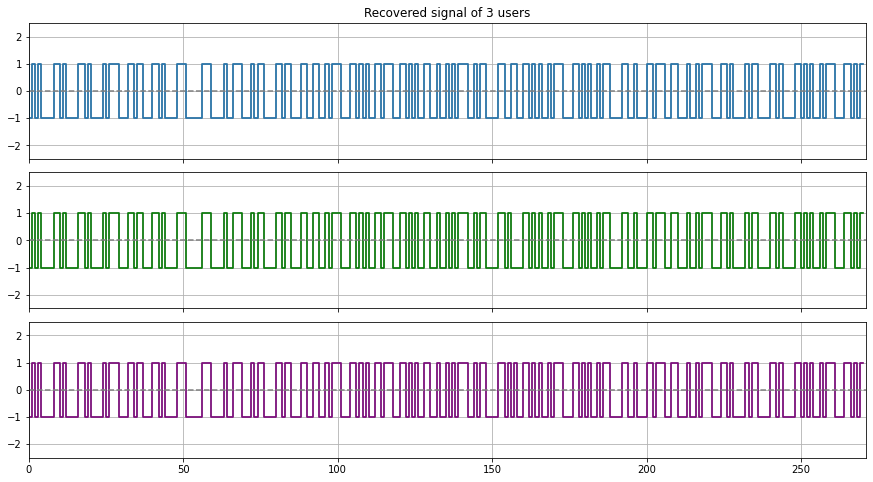

In [12]:
g, (ax0, ax1, ax2) = plt.subplots(3, sharex=True, sharey=True, figsize=(15,8))
ax0.set_title('Recovered signal of 3 users')
ax0.step(range(len(a1)),a1, color='gray')
ax0.step(range(len(a1)),a1)
ax0.axis((0,len(a1),-2.5,2.5))
ax0.axhline(color="gray", linestyle="dashed");ax0.grid()
ax2.step(range(len(a3)),a3, color='gray')
ax2.step(range(len(a3)),a3, color="purple")
ax2.axhline(color="gray", linestyle="dashed");ax1.grid()
ax1.step(range(len(a2)),a2, color='gray')
ax1.step(range(len(a2)),a2, color="green")
ax1.axhline(color="gray", linestyle="dashed");ax2.grid()
g.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [13]:
a1 = np.where(a1 <= -1.0, 0.0, a1)
a2 = np.where(a2 <= -1.0, 0.0, a2)
a3 = np.where(a3 <= -1.0, 0.0, a3)

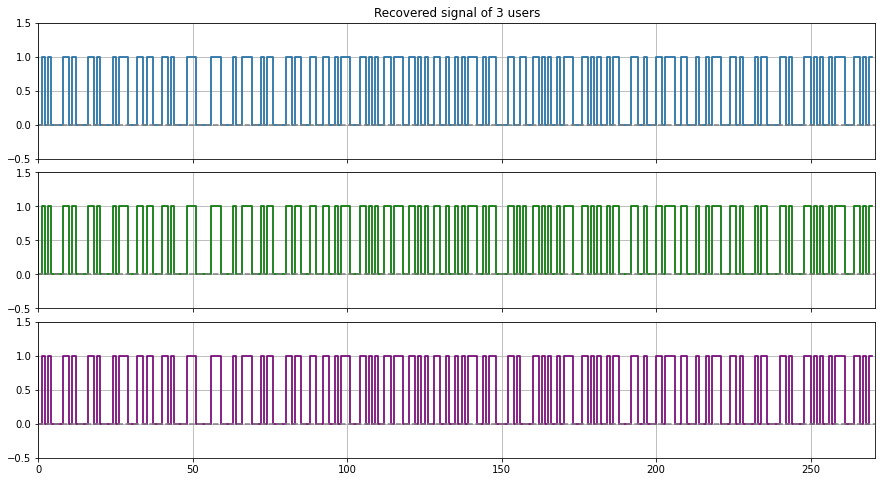

In [14]:
g, (ax0, ax1, ax2) = plt.subplots(3, sharex=True, sharey=True, figsize=(15,8))
ax0.set_title('Recovered signal of 3 users')
ax0.step(range(len(a1)),a1, color='gray')
ax0.step(range(len(a1)),a1)
ax0.axis((0,len(a1),-0.5,1.5))
ax0.axhline(color="gray", linestyle="dashed");ax0.grid()
ax1.step(range(len(a3)),a3, color='gray')
ax1.step(range(len(a3)),a3, color="green")
ax1.axhline(color="gray", linestyle="dashed");ax1.grid()
ax2.step(range(len(a2)),a2, color='gray')
ax2.step(range(len(a2)),a2, color="purple")
ax2.axhline(color="gray", linestyle="dashed");ax2.grid()
g.subplots_adjust(hspace=0.1)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

In [15]:
a1 = a1.astype(int)
a2 = a2.astype(int)
a3 = a3.astype(int)

In [16]:
# Python3 code to demonstrate  
# converting binary list to integer  
# using join() + list comprehension 
  
# initializing list  
test_list = a1
  
# printing original list 
print ("The original list is : " + str(test_list)) 
  
# using join() + list comprehension 
# converting binary list to integer  
res = int("".join(str(x) for x in test_list), 2) 
  
# printing result  
print ("\nThe converted integer value is : " +  str(res)) 
print("\n")
de = "{0:x}".format(res)
print("This is recovered MSG:",codecs.decode(de, "hex").decode('utf-8'))
print("\n")
print("This is original MSG:",s0)

The original list is : [1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1
 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1
 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1
 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0
 1 1 1 0 0 0 1 1 0 1 0 1]

The converted integer value is : 2496037877516781358812768934932254158649906044190398798242532281480869133822537269


This is recovered MSG: T44.6488N,63.5752W,35.5,271.4,45.5


This is original MSG: b'T44.6488N,63.5752W,35.5,271.4,45.5'


In [17]:
# Python3 code to demonstrate  
# converting binary list to integer  
# using join() + list comprehension 
  
# initializing list  
test_list = a2
  
# printing original list 
print ("The original list is : " + str(test_list)) 
  
# using join() + list comprehension 
# converting binary list to integer  
res = int("".join(str(x) for x in test_list), 2) 
  
# printing result  
print ("\nThe converted integer value is : " +  str(res)) 
print("\n")
de = "{0:x}".format(res)
print("This is recovered MSG:",codecs.decode(de, "hex").decode('utf-8'))
print("\n")
print("This is original MSG:",s1)

The original list is : [1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1
 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1
 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1
 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0
 1 1 1 0 0 0 1 1 0 1 0 1]

The converted integer value is : 2496037877516781358812768934932254158649906044195591095101067109109399630151757365


This is recovered MSG: T44.6488N,63.5752W,45.5,271.4,45.5


This is original MSG: b'T44.6488N,63.5752W,45.5,271.4,45.5'


In [18]:
# Python3 code to demonstrate  
# converting binary list to integer  
# using join() + list comprehension 
  
# initializing list  
test_list = a3
  
# printing original list 
print ("The original list is : " + str(test_list)) 
  
# using join() + list comprehension 
# converting binary list to integer  
res = int("".join(str(x) for x in test_list), 2) 
  
# printing result  
print ("\nThe converted integer value is : " +  str(res)) 
print("\n")
de = "{0:x}".format(res)
print("This is recovered MSG:",codecs.decode(de, "hex").decode('utf-8'))
print("\n")
print("This is original MSG:",s2)

The original list is : [1 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 0 1
 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 1
 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1
 0 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1
 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 0
 1 0 1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0
 1 1 1 0 0 0 1 1 0 1 0 1]

The converted integer value is : 2496037877516781358812768934932254158649906044200783391959601936737930126480977461


This is recovered MSG: T44.6488N,63.5752W,55.5,271.4,45.5


This is original MSG: b'T44.6488N,63.5752W,55.5,271.4,45.5'


## Enjoy Pythoning !